# Note book to save lat-long-orientation samples for GSV (Detroit as example)

## first extract osm

In [24]:
!gunzip -k cities_osm/detroit.osm.gz

### functions to read road networsk from osm data

In [43]:
import xml.etree.ElementTree as etree
import fiona
from shapely.geometry import shape, Point, Polygon, MultiPolygon
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

In [26]:
def isroad(tags):
    if 'highway' in tags:
        if tags['highway'] in ['motorway','trunk','primary','secondary','tertiary', 'residential', 'motorway_link']:
            return True
    return False

In [27]:
def getpaths(filterfunc):
    segments = []
    segments_coords = []
    counter = 0
    ways=[]
    for event, elem in etree.iterparse(pathOSM, events=('start', 'end')):
        if event == 'start':
            pass
        else:
            counter+=1
            if elem.tag=='node':
                elem.clear()
            if elem.tag=='relation':
                elem.clear()

            if elem.tag=='way':
                tags = {}
                subnodes = []
                for child in elem:
                    if child.tag=='tag':
                        tags[child.get('k')] = child.get('v')
                    if child.tag=='nd':
                        subnodes.append(int(child.get('ref')))
                if filterfunc(tags):
                    segments.append(subnodes)
                elem.clear()
            if counter%1000000==0:
                print(len(segments), counter)
            pass
    for seg in segments:
        segments_coords.append([nodes[nodeid] for nodeid in seg])
    return segments_coords


In [29]:
city, cityname = "detroit", "Detroit"

pathOSM = "cities_osm/{}.osm".format(city)
nodes = {}
counter = 0
for event, elem in etree.iterparse(pathOSM, events=('start', 'end')):
    if event == 'start':
        pass
    else:
        counter+=1
        if elem.tag=='node':
            nodes[int(elem.get('id'))] = [float(elem.get('lat')), float(elem.get('lon'))]
        if counter%1000000==0:
            print(len(nodes), counter)
        elem.clear()
        pass

921180 1000000
1861170 2000000
2790375 3000000
3126832 4000000
3126832 5000000
3126832 6000000
3126832 7000000
3126832 8000000
3126832 9000000


In [30]:
paths = getpaths(isroad)
print("Total roads:", len(paths))

0 1000000
0 2000000
0 3000000
16061 4000000
25799 5000000
26997 6000000
27473 7000000
28290 8000000
29500 9000000
Total roads: 30094


In [31]:
pathsnp = []
for path in paths:
    pathsnp.append(np.array(path)[:, ::-1])
pathsnpcat = np.concatenate(pathsnp)

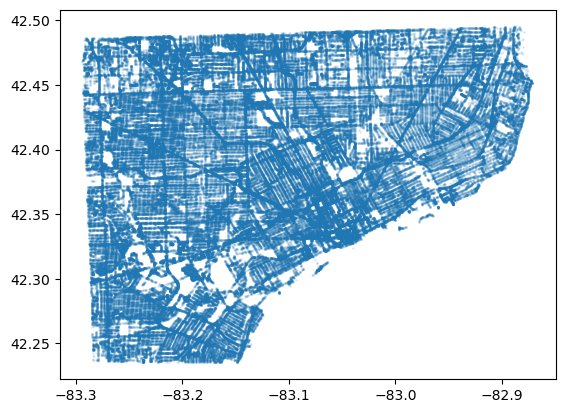

In [32]:
plt.scatter(pathsnpcat[:, 0], pathsnpcat[:, 1], s=1, alpha=0.1)

plt.show()

In [37]:
from fiona.crs import from_epsg
cityshape = fiona.open("{}/{}_4326.shp".format("cities", "cities"))
polys = []
for x in cityshape:
    # name is the name of the city
    if x['properties']['NAME']!=cityname:
        continue
    print(x['properties']['NAME'], "found")
    poly = shape(x['geometry'])
    # poly = poly.simplify(0.05)
    polys.append(poly)

Detroit found


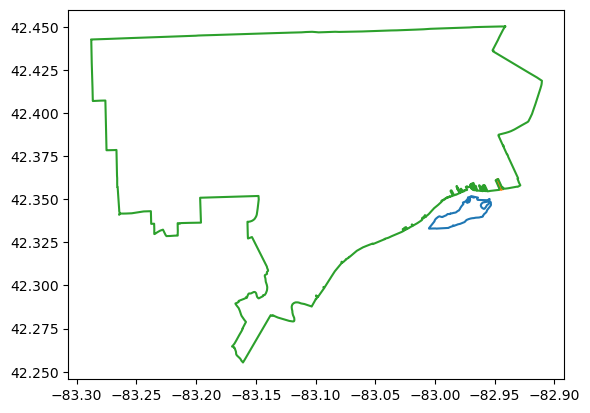

In [38]:
fig, ax = plt.subplots()
new_polys = []
for nbr in polys:
    if nbr.geom_type == 'Polygon':
        coords = nbr.exterior.coords
        new_coords = [(x, y) for x, y in coords]
        nbr = Polygon(new_coords)
        new_polys.append(nbr)
        x, y = nbr.exterior.xy
        ax.plot(x, y)
    else:
        nps = []
        for polygon in nbr.geoms:
            coords = polygon.exterior.coords
            new_coords = [(x, y) for x, y in coords]
            polygon = Polygon(new_coords)
            nps.append(polygon)
            x, y = polygon.exterior.xy
            ax.plot(x, y)
        nps = MultiPolygon(nps)
        new_polys.append(nps)

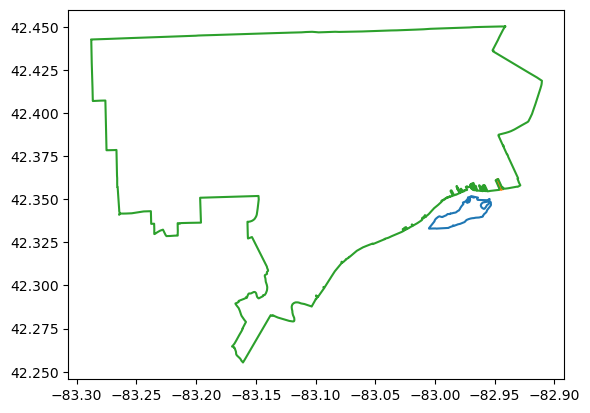

In [39]:
fig, ax = plt.subplots()
for nbr in new_polys:
    if nbr.geom_type == 'Polygon':
        x, y = nbr.exterior.xy
        ax.plot(x, y)
    else:
        nps = []
        for polygon in nbr.geoms:
            x, y = polygon.exterior.xy
            ax.plot(x, y)


## remove all paths outside the city boundary

In [41]:
inpathsnp = []
for i in range(len(pathsnp)):
    outsideinds = []
    for j in range(len(pathsnp[i])):
        point = pathsnp[i][j]
        pt = Point(point[0], point[1])
        inside = False
        # print(pt)
        for poly in new_polys:
            if poly.contains(pt):
                inside = True
                break
        if len(new_polys)==0:
            inside = True
        if not inside:
            outsideinds.append(j)
    if len(outsideinds)>0:
        newarr = np.delete(pathsnp[i], outsideinds, axis=0)
        if len(newarr)>1:
            inpathsnp.append(pathsnp[i][:])
    else:
        inpathsnp.append(pathsnp[i][:])
print(len(pathsnp))
print(len(inpathsnp))

30094
16103


16103
30094


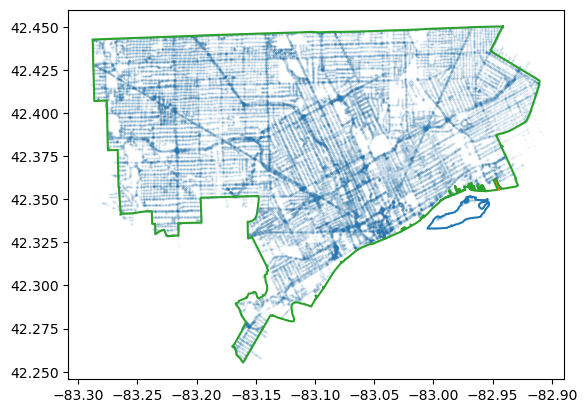

In [42]:
fig, ax = plt.subplots()
for nbr in polys:
    if nbr.geom_type == 'Polygon':
        x, y = nbr.exterior.xy
        ax.plot(x, y)
    else:
        for polygon in nbr.geoms:
            x, y = polygon.exterior.xy
            ax.plot(x, y)
print(len(inpathsnp))
print(len(pathsnp))
inpathsnpcat = np.concatenate(inpathsnp, axis=0)
ax.scatter(inpathsnpcat[:, 0], inpathsnpcat[:, 1], s=0.1, alpha=0.1)

## Assigning weights by length for sampling

In [45]:
def get_length(lineseg):
    return np.sum(norm(lineseg[1:]-lineseg[:-1], axis=1))

In [46]:
lengths = []
for linseg in inpathsnp:
    lengths.append(get_length(linseg))
lengths = np.array(lengths)/np.sum(lengths)

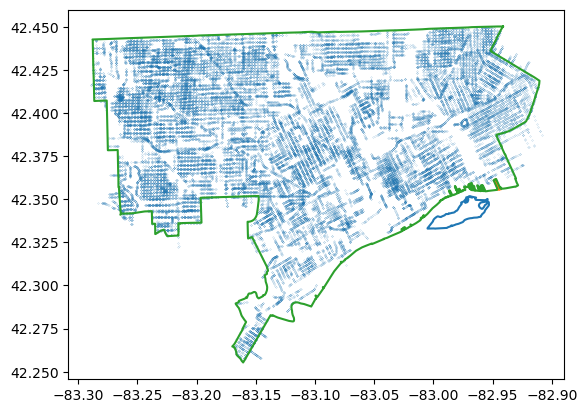

In [47]:
fig, ax = plt.subplots()
for nbr in polys:
    if nbr.geom_type == 'Polygon':
        x, y = nbr.exterior.xy
        ax.plot(x, y)
    else:
        for polygon in nbr.geoms:
            x, y = polygon.exterior.xy
            ax.plot(x, y)
maxlens = np.argsort(lengths)[::-1][:2000]
inpathsnpcat = np.concatenate([inpathsnp[tmp] for tmp in maxlens], axis=0)
ax.scatter(inpathsnpcat[:, 0], inpathsnpcat[:, 1], s=0.01)

## Important: set number of points to sample

In [49]:
num_samples = 5000

In [56]:
np.random.seed(42)
roadchoice = np.random.choice(len(lengths), num_samples*5, p=lengths)

In [57]:
def get_random_point_from_lineseg(lineseg):
    if len(lineseg)>2:
        dists = norm(lineseg[1:]-lineseg[:len(lineseg)-1], axis=1)
        choice = np.random.choice(len(dists), 1, p=dists/np.sum(dists))[0]
        line = lineseg[choice:choice+2]
    else:
        line = lineseg
    interp = np.random.uniform()
    sides = line[1]-line[0]
    heading = np.rad2deg(np.arctan2(sides[0], sides[1]))
    return interp*line[0]+(1-interp)*line[1], heading

In [58]:
sampledpoints = []
for road in roadchoice:
    pt, hd = get_random_point_from_lineseg(inpathsnp[road])
    sampledpoints.append(np.append(pt, hd))
sampledpoints = np.array(sampledpoints)

In [59]:
print(sampledpoints)

[[-83.12407652  42.41251662  -2.88675759]
 [-83.10810325  42.39621345 -33.66866721]
 [-83.26068329  42.37160298  88.17664705]
 ...
 [-82.98359547  42.38448844 -33.05780359]
 [-83.04430873  42.34222611  51.1393692 ]
 [-83.18026309  42.42490391 130.85347514]]


In [60]:
def fps(points, n_samples):
    points = np.array(points)
    points_left = np.arange(len(points)) # [P]
    sample_inds = np.zeros(n_samples, dtype='int') # [S]
    dists = np.ones_like(points_left) * float('inf') # [P]
    selected = 0
    sample_inds[0] = points_left[selected]
    points_left = np.delete(points_left, selected) # [P - 1]
    for i in range(1, n_samples):
        last_added = sample_inds[i-1]        
        dist_to_last_added_point = (
            (points[last_added] - points[points_left])**2).sum(-1) # [P - i]
        dists[points_left] = np.minimum(dist_to_last_added_point, 
                                        dists[points_left]) # [P - i]
        selected = np.argmax(dists[points_left])
        sample_inds[i] = points_left[selected]
        points_left = np.delete(points_left, selected)
    return sample_inds

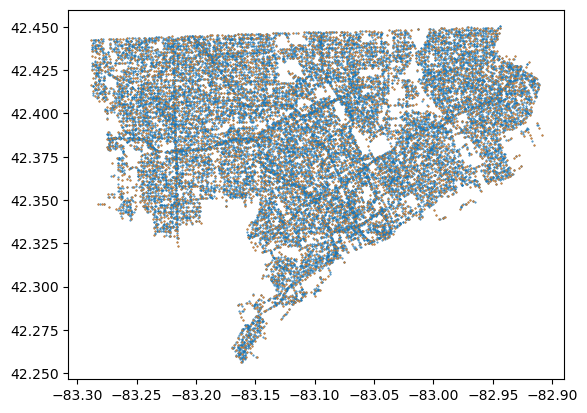

In [65]:
sample_inds = fps(sampledpoints[:, :2], num_samples)
plt.scatter(sampledpoints[:, 0], sampledpoints[:, 1], s=0.2, alpha=1)
plt.scatter(sampledpoints[sample_inds, 0], sampledpoints[sample_inds, 1], s=0.2, alpha=1)

In [66]:
print(city, len(sample_inds))
np.save('samples_{}.npy'.format(city), sampledpoints[sample_inds])

detroit 5000


### This will save a npy file with locations and orientations. Use `streetview_dowloader.py` to download images from these locations.